# Analysis

## Read data

In [25]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

from numpy.random import seed
seed(1)

In [3]:
print(os.listdir("./"))

['analise-sus.ipynb', '.DS_Store', 'requirements.txt', 'ubs.csv', '.ipynb_checkpoints']


In [4]:
ubs = pd.read_csv('./ubs.csv')
ubs.shape

(37690, 13)

## Data Processing

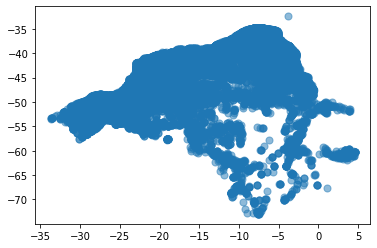

In [57]:
ubs.head()

plt.scatter(ubs['vlr_latitude'], ubs['vlr_longitude'], s=50, alpha=0.5)
plt.show()

<AxesSubplot:>

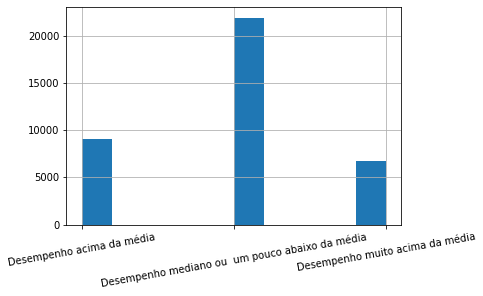

In [6]:
ubs['dsc_estrut_fisic_ambiencia'].hist(xlabelsize=10, xrot=10)

<AxesSubplot:>

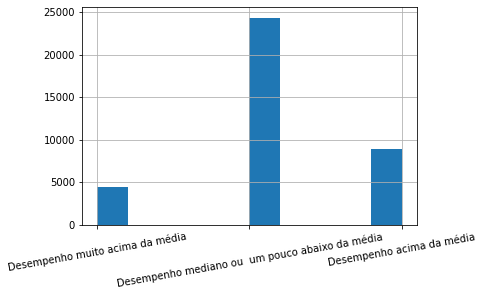

In [7]:
ubs['dsc_adap_defic_fisic_idosos'].hist(xlabelsize=10, xrot=10)

<AxesSubplot:>

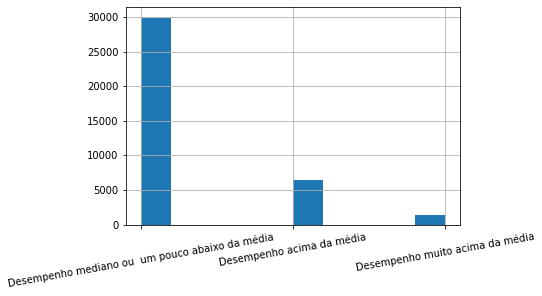

In [8]:
ubs['dsc_equipamentos'].hist(xlabelsize=10, xrot=10)

<AxesSubplot:>

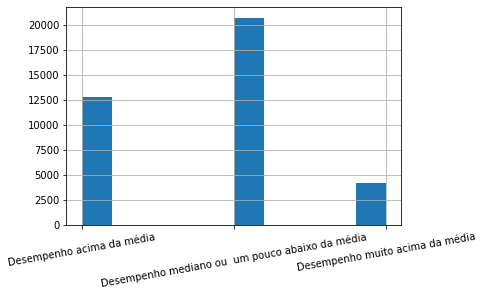

In [9]:
ubs['dsc_medicamentos'].hist(xlabelsize=10, xrot=10)

In [10]:
bad = "Desempenho mediano ou  um pouco abaixo da média"
bad_physical = ubs['dsc_estrut_fisic_ambiencia'] == bad
bad_elderly = ubs['dsc_adap_defic_fisic_idosos'] == bad
bad_equipment = ubs['dsc_equipamentos'] == bad
bad_medication = ubs['dsc_medicamentos'] == bad

generally_bad = bad_physical & bad_elderly & bad_equipment & bad_medication

selected_ubs = ubs[generally_bad]
selected_ubs

,vlr_latitude,vlr_longitude,cod_munic,cod_cnes,nom_estab,dsc_endereco,dsc_bairro,dsc_cidade,dsc_telefone,dsc_estrut_fisic_ambiencia,dsc_adap_defic_fisic_idosos,dsc_equipamentos,dsc_medicamentos
1,-9.485943,-35.857573,270770,6685315,USF ENFERMEIRO PEDRO JACINTO AREA 09,R 15 DE AGOSTO,CENTRO,Rio Largo,Não se aplica,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média
5,-7.037151,-37.288799,251080,6713971,UNIDADE DE SAUDE DA FAMILIA ANA RAQUEL,RUA SEVERINO SOARES,JD GUANABARA,Patos,Não se aplica,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média
8,-5.897952,-44.816000,211230,2450801,UNIDADE BASICA DE SAUDE JOSE BIBI,POVOADO SAO JOAQUIM DOS MELOS,ZONA RURAL,Tuntum,9935225071,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média
10,-3.090602,-59.986489,130260,2014815,UBS L 29,RUA FLAVIO COSTA,COROADO I,Manaus,9232492767,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média
15,-29.608862,-51.174531,431080,2230313,POSTO MORADA DO SOL IVOTI,RUA CAXIAS DO SUL,JARDIM BUHLER,Ivoti,35636067,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37683,-7.058383,-41.406419,220800,2693992,POSTO DE SAUDE DE LAGOA GRANDE,LOCALIDADE LAGOA GRANDE,NaN,Picos,(89) 4154252,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média
37684,-15.465177,-57.989445,510562,2395169,POSTO DE SAUDE ASSENTAM ST HELENA,COMUNIDADE SANTA HELENA,NaN,Mirassol d'Oeste,(65)02411914,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média
37685,-9.900699,-44.541235,220320,2490390,PS DO ESPIRITO SANTO,ESPIRITO SANTO,NaN,Curimatá,Não se aplica,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média
37686,-12.165245,-61.709883,110029,2744155,PS LINHA P 18 NOVA SANTA LUZIA DOESTE,LINHA P 18 NOVA,NaN,Santa Luzia D'Oeste,Não se aplica,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média


In [23]:
ubs_space = selected_ubs.iloc[:,0:2]
ubs_space

,vlr_latitude,vlr_longitude
1,-9.485943,-35.857573
5,-7.037151,-37.288799
8,-5.897952,-44.816000
10,-3.090602,-59.986489
15,-29.608862,-51.174531
...,...,...
37683,-7.058383,-41.406419
37684,-15.465177,-57.989445
37685,-9.900699,-44.541235
37686,-12.165245,-61.709883


[[ -4.7855725  -54.96130369]
 [-22.02614981 -46.80436068]
 [ -7.64070637 -40.24441716]]


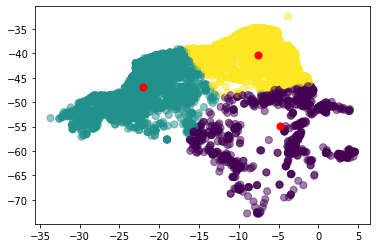

In [24]:
kmeans = KMeans(n_clusters=3).fit(ubs_space)
centroids = kmeans.cluster_centers_
print(centroids)

plt.scatter(ubs_space['vlr_latitude'], ubs_space['vlr_longitude'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()

In [34]:
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, ubs_space)
closest

array([4263, 1825, 3923])

In [53]:
selected_ubs.iloc[closest]

,vlr_latitude,vlr_longitude,cod_munic,cod_cnes,nom_estab,dsc_endereco,dsc_bairro,dsc_cidade,dsc_telefone,dsc_estrut_fisic_ambiencia,dsc_adap_defic_fisic_idosos,dsc_equipamentos,dsc_medicamentos
15630,-4.097825,-54.906127,150619,2620030,CENTRO DE ATENCAO BAS E EPID GEN,AVENIDA 7 DE SETEMBRO,CENTRO,Rurópolis,(93)35431328,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média
6796,-22.059184,-46.976724,350030,2065002,CENTRO DE SAUDE III EUFROZINA MARIA DE JESUS A...,PC GOVERNADOR CARVALHO PINTO,CENTRO,Aguaí,1936526161,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média
14479,-7.760789,-40.267017,261560,2707039,USF CENTRO,RUA OSVALDO CRUZ,CENTRO,Trindade,(87)38701074,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média
